# Importing Libraries and Loading Data

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import random
f = open("mag_derv.grd", "r")
a = f.read()
z1 =a.split("\n")
cs =[]
for i in z1:
    if i!="":
        cs.append(i)
d1=[]
for i in cs:
    d = i.split(" ")[:-1]
    d1.append(d)
d2 = np.concatenate(d1[:-1])
index=[]
for j,i in enumerate(d1):
    if len(i)==1:
        index.append(j)
ssd=[]
for k in range(len(index)-1):
    if len(index)!=k:
        zx = d2[index[k]:index[k+1]]
        ssd.append(zx.reshape(1,-1))

data = np.concatenate(ssd,axis=0)
data = pd.DataFrame(data.astype("float32"))
data = data.dropna(how="all",axis=0).interpolate()
data = data.dropna(how="any").reset_index(drop=True)
original_data = data

# Adding Gaussian and Poisson Noise

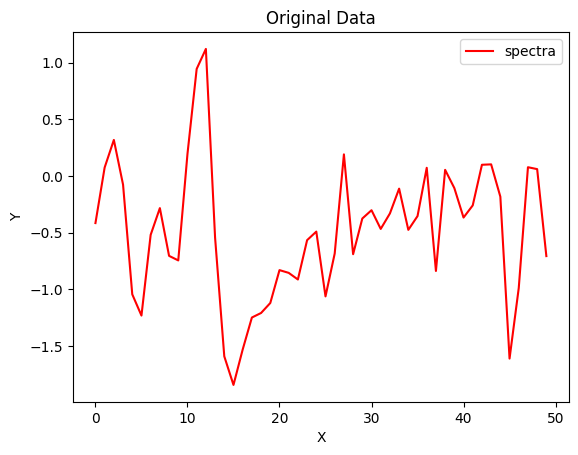

In [84]:
# Add Gaussian noise
mean = 0
std_deviation = 25
#adding seed
rnd_seed = 42
rng = np.random.default_rng(seed=rnd_seed)
#change 0.0001 to 0.0001
gaussian_noise = 0.01 * rng.normal(mean, std_deviation, original_data.shape)
#gaussian_noisy_data = original_data + np.random.normal(mean, std_deviation, original_data.shape)
# Add Poisson noise
lambda_value = 10
#change 0.001 to 0.0001
poisson_noise =  0.01 * (rng.poisson(lambda_value, original_data.shape) - lambda_value)
#poisson_noisy_data = np.random.poisson(lambda_value, original_data.shape)

plt.plot(np.arange(0,len(data.columns)), data.iloc[0].T, color='red', label='spectra')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data')
plt.legend()
plt.show()



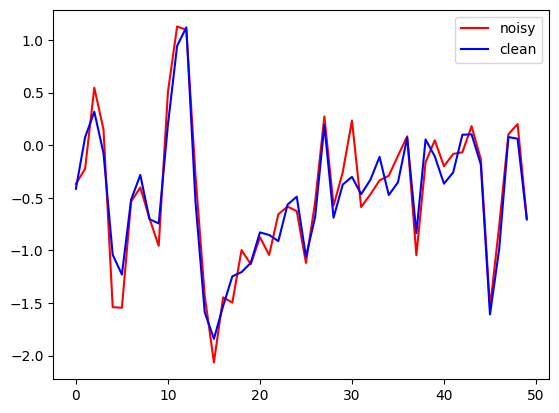

In [85]:
# combining two noise
noisy_data = original_data + gaussian_noise + poisson_noise
# save the noisy data to a new .npz file
lables = data
plt.plot(np.arange(0,len(data.columns)), noisy_data.iloc[0].T, color='red', label='noisy')
plt.plot(np.arange(0,len(data.columns)), lables.iloc[0].T, color='blue', label='clean')
plt.legend()




In [86]:
X_train, X_val, y_train, y_val = train_test_split(noisy_data, lables, test_size=0.2, random_state=42)

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(noisy_data, lables, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2 / (1-0.2), random_state=42)

index_train, index_test, _, _ = train_test_split(np.arange(len(noisy_data)), np.arange(len(noisy_data)), test_size=0.2, random_state=42)
index_train, index_val, _, _ = train_test_split(index_train, index_train, test_size=0.2 / (1-0.2), random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(noisy_data, lables, test_size=0.2, random_state=42)

In [87]:
print("Original set - Input shape:", noisy_data.shape, "Output shape:", lables.shape)
print("Training set - Input shape:", X_train.shape, "Output shape:", y_train.shape)
print("Validation set - Input shape:", X_val.shape, "Output shape:", y_val.shape)
print("Testing set - Input shape:", X_test.shape, "Output shape:", y_test.shape)



Original set - Input shape: (24, 50) Output shape: (24, 50)
Training set - Input shape: (14, 50) Output shape: (14, 50)
Validation set - Input shape: (5, 50) Output shape: (5, 50)
Testing set - Input shape: (5, 50) Output shape: (5, 50)


# CNN filtering

Epoch 1/50
1/1 [==============================] - 1s 707ms/step - loss: 3.7474 - val_loss: 2.4936
Epoch 2/50
1/1 [==============================] - 0s 40ms/step - loss: 3.0176 - val_loss: 1.9998
Epoch 3/50
1/1 [==============================] - 0s 37ms/step - loss: 2.4098 - val_loss: 1.6063
Epoch 4/50
1/1 [==============================] - 0s 57ms/step - loss: 1.9157 - val_loss: 1.3108
Epoch 5/50
1/1 [==============================] - 0s 36ms/step - loss: 1.5308 - val_loss: 1.1080
Epoch 6/50
1/1 [==============================] - 0s 34ms/step - loss: 1.2475 - val_loss: 0.9877
Epoch 7/50
1/1 [==============================] - 0s 35ms/step - loss: 1.0544 - val_loss: 0.9347
Epoch 8/50
1/1 [==============================] - 0s 38ms/step - loss: 0.9356 - val_loss: 0.9306
Epoch 9/50
1/1 [==============================] - 0s 36ms/step - loss: 0.8721 - val_loss: 0.9544
Epoch 10/50
1/1 [==============================] - 0s 40ms/step - loss: 0.8423 - val_loss: 0.9860
Epoch 11/50
1/1 [===========

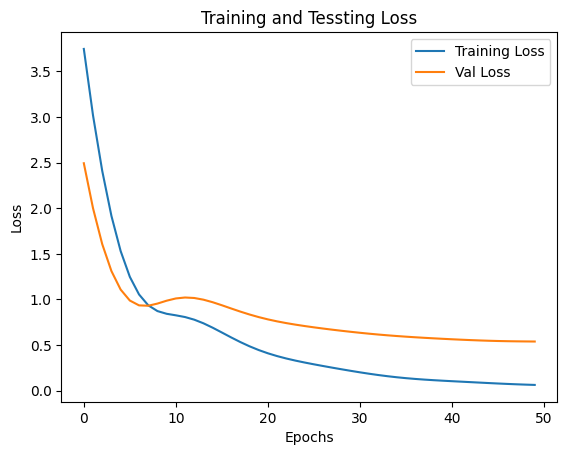

In [88]:
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
#from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import Conv1D, MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(50, 1)))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
model.add(Dense(50))  # Output layer with 1 neuron for regression

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
denoised_data = model.predict(X_test)

print(denoised_data)
len(denoised_data)

model.save_weights("model.h5")
model.summary()



# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Tessting Loss')
plt.legend()
plt.show()





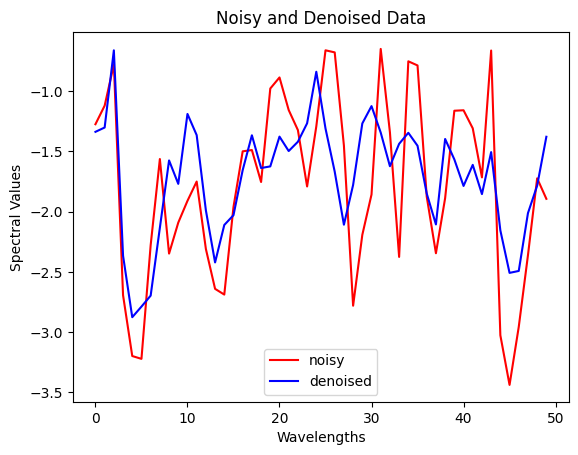

In [89]:
plt.plot(np.arange(0,len(data.columns)), noisy_data.iloc[index_test[0]].T, color='red', label='noisy')
plt.plot(np.arange(0,len(data.columns)), denoised_data[0].T, color='blue', label='denoised')
plt.xlabel('Wavelengths')
plt.ylabel('Spectral Values')
plt.title('Noisy and Denoised Data')
plt.legend()
plt.show()

In [90]:
denoised_data = model.predict(noisy_data)

1/1 [==============================] - 0s 21ms/step


# Median Filtering

In [91]:
import numpy
from PIL import Image


def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = []
    data_final = numpy.zeros((len(data),len(data[0])))
    for i in range(len(data)):

        for j in range(len(data[0])):

            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final



removed_noise = median_filter(np.array(data), 2)
removed_noise

array([[ 0.        ,  0.        ,  0.075072  , ...,  0.        ,
         0.06077143,  0.        ],
       [-0.65140003,  0.005296  ,  0.31799999, ..., -0.09125713,
         0.06440429,  0.        ],
       [-0.88065004, -0.06448   ,  0.43520001, ..., -0.26002857,
         0.06440429,  0.        ],
       ...,
       [-1.17925   , -1.83500004, -1.83500004, ..., -2.61199999,
        -2.64899993,  0.        ],
       [-0.3495    , -1.0151    , -1.0151    , ..., -2.204     ,
        -2.21600008,  0.        ],
       [-0.3039    , -0.3039    , -0.49419999, ..., -1.76999998,
        -1.74800003,  0.        ]])

# Gaussian Smoothening Filter

In [92]:
import scipy.ndimage as ndimage

In [93]:
img = ndimage.gaussian_filter(np.array(data), sigma=(0.4), order=0)

# Wavelet Denoising

In [94]:
from  skimage.restoration._denoise import denoise_wavelet

In [95]:
denoised_img = denoise_wavelet(np.array(data), sigma=0.5, rescale_sigma=True)

# Comparison

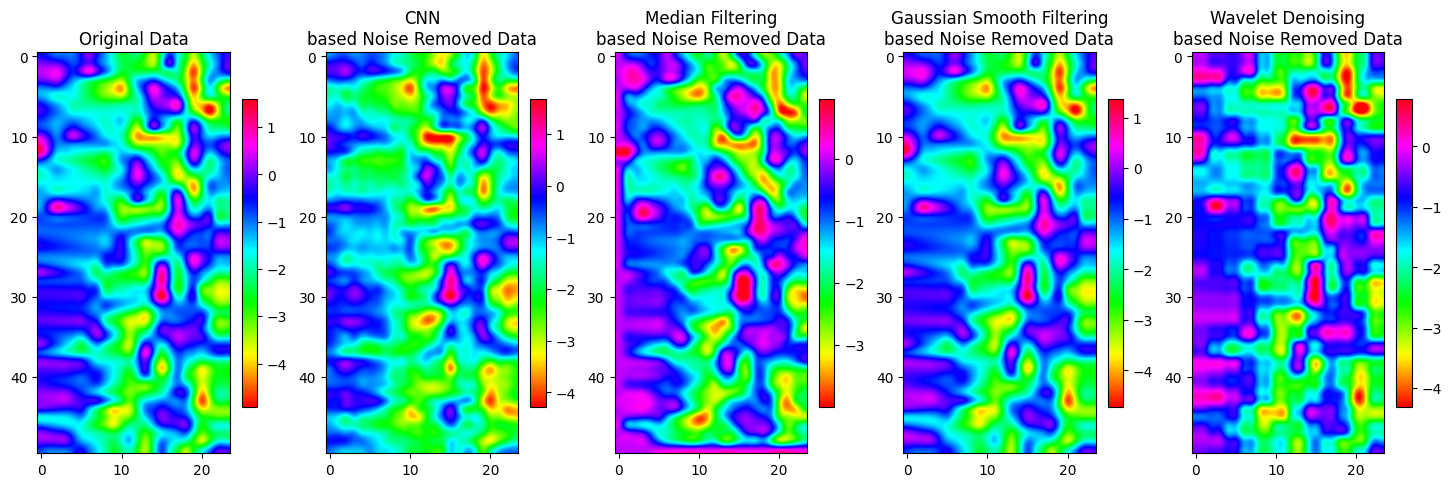

In [103]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(18,20))
a = ax[0].imshow(data.T,cmap="hsv",interpolation="spline36")
ax[0].set_title("Original Data")
fig.colorbar(a, shrink=0.2)

b = ax[1].imshow(denoised_data.T,cmap="hsv",interpolation="spline36")
ax[1].set_title("CNN\nbased Noise Removed Data")
fig.colorbar(b, shrink=0.2)

c = ax[2].imshow(removed_noise.T,cmap="hsv",interpolation="spline36")
ax[2].set_title("Median Filtering\nbased Noise Removed Data")
fig.colorbar(c, shrink=0.2)


d = ax[3].imshow(img.T,cmap="hsv",interpolation="spline36")
ax[3].set_title("Gaussian Smooth Filtering\nbased Noise Removed Data")
fig.colorbar(d, shrink=0.2)

e = ax[4].imshow(denoised_img.T,cmap="hsv",interpolation="spline36")
ax[4].set_title("Wavelet Denoising\nbased Noise Removed Data")
fig.colorbar(e, shrink=0.2)


In [99]:
help(fig.colorbar)

Help on method colorbar in module matplotlib.figure:

colorbar(mappable, cax=None, ax=None, use_gridspec=True, **kwargs) method of matplotlib.figure.Figure instance
    Add a colorbar to a plot.
    
    Parameters
    ----------
    mappable
        The `matplotlib.cm.ScalarMappable` (i.e., `.AxesImage`,
        `.ContourSet`, etc.) described by this colorbar.  This argument is
        mandatory for the `.Figure.colorbar` method but optional for the
        `.pyplot.colorbar` function, which sets the default to the current
        image.
    
        Note that one can create a `.ScalarMappable` "on-the-fly" to
        generate colorbars not attached to a previously drawn artist, e.g.
        ::
    
            fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    
    cax : `~matplotlib.axes.Axes`, optional
        Axes into which the colorbar will be drawn.
    
    ax : `~.axes.Axes` or iterable or `numpy.ndarray` of Axes, optional
        One or more parent axes from wh